# Calculating Recency, Frequency and Monetary (RFM)

## 1. Introduction   

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

Businesses that lack the monetary aspect, like viewership, readership, or surfing-oriented products, could use Engagement parameters instead of Monetary ones. This results in using **RFE** (Recency, Frequency, Engagement) – a variation of RFM. Further, this Engagement parameter could be defined as a composite value based on metrics such as bounce rate, visit duration, number of pages visited, time spent per page, etc.

RFM features of customers illustrates these characteristics:
* The more recent they purchase, the more responsive they are to the promotions.
* The more frequent they purchase, the more engaged and satisfied they are.
* The more monetary value helps to differentiate high spenders vs low spenders.

## 1.1 Sources
- [RFM Modeling](https://medium.com/analytics-vidhya/marketing-analytics-rfm-modeling-855ebec18014)
- [K-Means](https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444)
- [Online Retail Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/)

## 2. Import libraries

In [272]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [273]:
import pandas as pd
from datetime import timedelta
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import squarify

## 3. Read data from CSV

In [237]:
df = pd.read_csv('data/online_retail.csv', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 4. Preparing the data

In [238]:
# Only keep the columns we actually need
df = df[['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']]

In [239]:
# Removing null CustomerIDs
df = df[pd.notnull(df['CustomerID'])]

In [240]:
# Calculating total sales
df['TotalSales'] = df['Quantity'].multiply(df['UnitPrice'])

In [241]:
# Show the result
df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalSales
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34


## 5. Calculating RFM step-by-step

In [242]:
# Create dataframe of all unique users
customers = pd.DataFrame(df['CustomerID'].unique())
customers.columns = ['CustomerID']

### 5.1. Calculate Recency

In [243]:
# Get latest order date
latest_order = df['InvoiceDate'].max() + timedelta(1)

# Get max invoice date for each customer
max_purchase = df.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']

# Calculate recency as 'days between customer's last order and overall last order'
max_purchase['Recency'] = (latest_order - max_purchase['MaxPurchaseDate']).dt.days

# Merge with customer data frame
customers = pd.merge(customers, max_purchase[['CustomerID','Recency']], on='CustomerID')

### 5.2. Calculate Frequency

In [244]:
# Count orders for each customer
frequency = df.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

# Merge with customer data frame
customers = pd.merge(customers, frequency, on='CustomerID')

### 5.3. Calculate Monetary

In [245]:
# Add up all sales for each customer
monetary = df.groupby('CustomerID').TotalSales.sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

# Merge with customer data frame
customers = pd.merge(customers, monetary, on='CustomerID')

### 5.4. Results

In [246]:
customers.sort_values('CustomerID').head()

,CustomerID,Recency,Frequency,Monetary
1169,12346.0,326,2,0.00
438,12347.0,2,182,4310.00
873,12348.0,75,31,1797.24
4238,12349.0,19,73,1757.55
1419,12350.0,310,17,334.40


## 6. Calculating RFM using a convenience function

### 6.1. Defining the function

In [247]:
def calculate_rfm(df, customerID, invoiceDate, transactionID, sales):
    ''' Create the Recency, Frequency, and Monetary features from the data '''
    # Final date in the data + 1 to create latest date
    latest_date = df[invoiceDate].max() + timedelta(1)
    
    # RFM feature creation
    RFMScores = df.groupby(customerID).agg({invoiceDate: lambda x: (latest_date - x.max()).days, 
                                          transactionID: lambda x: len(x), 
                                          sales: lambda x: sum(x)})
    
    # Converting invoiceDate to int since this contains number of days
    RFMScores[invoiceDate] = RFMScores[invoiceDate].astype(int)
    
    # Renaming column names to Recency, Frequency and Monetary
    RFMScores.rename(columns={invoiceDate: 'Recency', 
                         transactionID: 'Frequency', 
                         sales: 'Monetary'}, inplace=True)
    
    return RFMScores.reset_index()

### 6.2. Applying the function

In [248]:
rfm = calculate_rfm(df=df, customerID="CustomerID", invoiceDate="InvoiceDate", transactionID="InvoiceNo", sales="TotalSales")

### 6.3. Results

In [249]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


## 7. RFM Segmentation using Quantiles

### 7.1. Preparation

In [250]:
rfm_quantiles = rfm.copy()

In [251]:
def rank_rfm(value, column, quantiles, ascending=True):
    '''Ranking the Recency, Frequency, and Monetary features based on quantile values.'''
    if value <= quantiles[column][0.25]:
        return 0 if ascending else 3
    elif value > quantiles[column][0.25] and value <= quantiles[column][0.5]:
        return 1 if ascending else 2
    elif value > quantiles[column][0.5] and value <= quantiles[column][0.75]:
        return 2 if ascending else 1
    else:
        return 3 if ascending else 0

### 7.2. Determine quantiles

In [252]:
quantiles = rfm_quantiles[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75]).to_dict()

### 7.3. Building the clusters

In [253]:
rfm_quantiles['RecencyCluster'] = rfm_quantiles['Recency'].apply(lambda x: rank_rfm(x, 'Recency', quantiles, False))
rfm_quantiles['FrequencyCluster'] = rfm_quantiles['Frequency'].apply(lambda x: rank_rfm(x, 'Frequency', quantiles))
rfm_quantiles['MonetaryCluster'] = rfm_quantiles['Monetary'].apply(lambda x: rank_rfm(x, 'Monetary', quantiles))

### 7.4. Results

In [254]:
rfm_quantiles.head()

,CustomerID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster
0,12346.0,326,2,0.00,0,0,0
1,12347.0,2,182,4310.00,3,3,3
2,12348.0,75,31,1797.24,1,1,3
3,12349.0,19,73,1757.55,2,2,3
4,12350.0,310,17,334.40,0,0,1


## 8. RFM Segments using k-means

### 8.1. Preparation

In [255]:
rfm_kmeans = rfm.copy()

In [256]:
rfm_kmeans.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


In [257]:
def order_cluster(df, cluster_field_name, target_field_name, ascending=True):
    '''Order k-means clusters'''
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index": cluster_field_name})

    return df_final

### 8.2. Determine optimal number of clusters

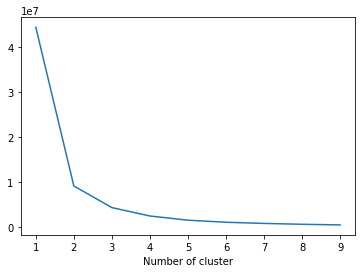

In [258]:
# Container for all sums of squared errors
sse = {}
recency = rfm[['Recency']].copy()

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency['Clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

Using the 'Elbow method' we choose 4 as our number of clusters

In [259]:
n_clusters = 4

### 8.3. Building the Recency cluster

In [260]:
# Determine clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_kmeans[['Recency']])
rfm_kmeans['RecencyCluster'] = kmeans.predict(rfm[['Recency']])

# Order clusters
rfm_kmeans = order_cluster(rfm_kmeans, 'RecencyCluster', 'Recency', False)

### 8.4. Building the Frequency cluster

In [261]:
# Determine clusters
kmeans = KMeans(n_clusters)
kmeans.fit(rfm[['Frequency']])
rfm_kmeans['FrequencyCluster'] = kmeans.predict(rfm_kmeans[['Frequency']])

# Order clusters
rfm_kmeans = order_cluster(rfm_kmeans, 'FrequencyCluster', 'Frequency')

### 8.5. Building the Monetary cluster

In [262]:
# Determine clusters
kmeans = KMeans(n_clusters)
kmeans.fit(rfm[['Monetary']])
rfm_kmeans['MonetaryCluster'] = kmeans.predict(rfm_kmeans[['Monetary']])

# Order clusters
rfm_kmeans = order_cluster(rfm_kmeans, 'MonetaryCluster', 'Monetary')

### 8.6. Results

In [263]:
rfm_kmeans.head()

,CustomerID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster
0,12346.0,326,2,0.00,0,0,0
1,12350.0,310,17,334.40,0,0,0
2,12361.0,287,10,189.90,0,0,0
3,12365.0,291,23,320.69,0,0,0
4,12373.0,311,14,364.60,0,0,0


## 9. RFM Segmentation

### 9.1. Calculating RFM Score

In [264]:
rfm_kmeans['Score'] = rfm_kmeans[['RecencyCluster', 'FrequencyCluster', 'MonetaryCluster']].sum(axis=1)

### 9.2. Calculating RFM Segment

In [265]:
rfm_kmeans['Segment'] = rfm_kmeans['RecencyCluster'].apply(str) + rfm_kmeans['FrequencyCluster'].apply(str) + rfm_kmeans['MonetaryCluster'].apply(str)

### 9.3. Bucketizing Customers based on Score

In [280]:
# Applying loyalty levels according to the Overall Score
labels = ['Bronze', 'Silver', 'Gold', 'Platinum']
rfm_kmeans['Level'] = pd.cut(rfm_kmeans['Score'], 4, labels=labels)

### 9.4. Results

In [281]:
rfm_kmeans.head()

,CustomerID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,Score,Segment,Loyalty_Level,Level
0,12346.0,326,2,0.00,0,0,0,0,000,Bronze,Bronze
1,12350.0,310,17,334.40,0,0,0,0,000,Bronze,Bronze
2,12361.0,287,10,189.90,0,0,0,0,000,Bronze,Bronze
3,12365.0,291,23,320.69,0,0,0,0,000,Bronze,Bronze
4,12373.0,311,14,364.60,0,0,0,0,000,Bronze,Bronze


### 9.5 Show distribution

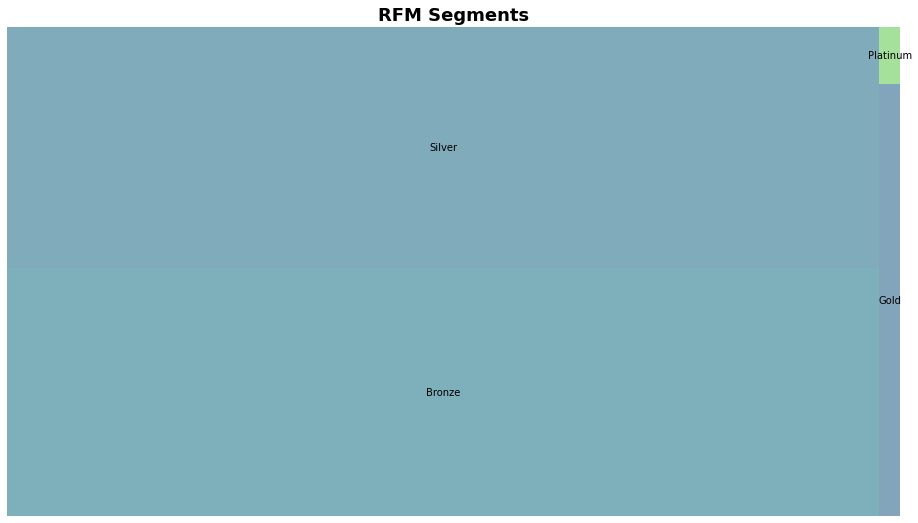

In [296]:
# Count customers in each level
rfm_level_agg = rfm_kmeans['Level'].value_counts().rename_axis('Levels').to_frame('Count')

# Prepare plot
fig = plt.gcf()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], label=labels, alpha=.6)
plt.title('RFM Segments', fontsize=18, fontweight='bold')
plt.axis('off')

# Plot
plt.show()